## Segmentation CNN

@ysbecca
Basic CNN to perform segmentation of training set based on layers:
- epithelial layer
- submucosa

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.python.client import device_lib
from importlib import reload
import math    

import time
from datetime import timedelta

import scripts.helper_functions as hf
import scripts.cnn_helper as cn
import scripts.dataset as ds

In [2]:
reload(ds)

<module 'scripts.dataset' from '/Users/ysbecca/ysbecca-projects/bcsp-expert/scripts/dataset.py'>

Parameters.

In [64]:
checkpoints_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/checkpoints/"

# Image params
img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)

# Convolutional layer params
filter_sizes = [3, 3]
num_filters = [16, 32]
num_layers = len(filter_sizes)

max_pools = [2, 2]

# Fully connected layers, followed by classification layer.
fc_1_size = 128

num_classes = 2
weight_values = [1.0, 4.5] # 4= 20/80 split

Build TensorFlow graph structure.

In [65]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.int8, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32) # So that we can control dropout.

weights = tf.placeholder(tf.float32, shape=[None], name='weights')

Find device configuration.

In [66]:
gpus = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
num_gpus = len(gpus)
print("GPU devices found: " + str(gpus))

GPU devices found: []


Define model.

In [67]:
def model(x_image_, y_true_, weights_):
    ''' Expecting the following parameters, in batches:
        x_image_ - x_image
        y_true_ - y_true
    '''
    network, _ = cn.new_conv_layer(input=x_image_,
                                  num_input_channels=num_channels,
                                  filter_size=filter_sizes[0],
                                  num_filters=num_filters[0],
                                  use_pooling=True,
                                  max_pool_size=max_pools[0])
    
    network = tf.nn.dropout(network, keep_prob=keep_prob)
    network, _ = cn.new_conv_layer(input=network,
                                  num_input_channels=num_filters[0],
                                  filter_size=filter_sizes[1],
                                  num_filters=num_filters[1],
                                  use_pooling=True,
                                  max_pool_size=max_pools[1])
    network = tf.nn.dropout(network, keep_prob=keep_prob)
    network, num_fc_features = cn.flatten_layer(network) # 256
    
    # Flatten and build the fully-connected layers.
    network, _ = cn.new_fc_layer(input=network,
                             num_inputs=num_fc_features,
                             num_outputs=fc_1_size,
                             use_relu=False)
    network, _ = cn.new_fc_layer(input=network,          
                             num_inputs=fc_1_size,
                             num_outputs=num_classes,
                             use_relu=True)

    y_pred = tf.nn.softmax(network)                    
    y_pred_cls = tf.argmax(network, dimension=1)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=network, labels=y_true_)
    #cost = tf.reduce_mean(cross_entropy)
    cost = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=network, onehot_labels=y_true_, weights=weights_))
    
    return y_pred, y_pred_cls, cost


Split operations (optionally) across GPUs.

In [68]:
def make_parallel(fn, num_gpus, **kwargs):
    in_splits = {}
    for k, v in kwargs.items():
        in_splits[k] = tf.split(v, num_gpus)

    y_pred_split, y_pred_cls_split, cost_split = [], [], []
    for i in range(num_gpus):
        with tf.device(tf.DeviceSpec(device_type="GPU", device_index=i)):
            with tf.variable_scope(tf.get_variable_scope(), reuse=i > 0):
                y_pred_, y_pred_cls_, cost_ = fn(**{k : v[i] for k, v in in_splits.items()})
                y_pred_split.append(y_pred_)
                y_pred_cls_split.append(y_pred_cls_)
                cost_split.append(cost_)

    return tf.concat(y_pred_split, axis=0), tf.concat(y_pred_cls_split, axis=0), tf.stack(cost_split, axis=0)

if num_gpus > 0:
    total_batches = num_gpus
else:
    total_batches = 1

# train_batch_size = train_batch_size * total_batches
# test_batch_size = test_batch_size * total_batches

Define cost and loss functions.

In [69]:
if num_gpus > 0:
    # Remember that this adds significant latency for CPU<->GPU copying of shared variables.
    # 2 GPU's is enough to get a good balance between speedup and minimal latency (12 GB on k80 nodes)
    y_pred, y_pred_cls, cost = make_parallel(model, num_gpus, x_image_=x_image, y_true_=y_true, weights_=weights)
else:
    # CPU-only version
    y_pred, y_pred_cls, cost = model(x_image_=x_image, y_true_=y_true, weights_=weights)
    
optimizer = tf.train.AdagradOptimizer(learning_rate=1e-4).minimize(cost)
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Tensor("Conv2D_8:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("Relu_12:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("MaxPool_8:0", shape=(?, 16, 16, 16), dtype=float32)
Tensor("Conv2D_9:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("Relu_13:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("MaxPool_9:0", shape=(?, 8, 8, 32), dtype=float32)


Start session!

In [70]:
if num_gpus > 0: # Log GPU/CPU placement to the terminal if using GPU's.
    session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
else:
    session = tf.Session()
    
session.run(tf.global_variables_initializer())
saver = tf.train.Saver() # For when we want to save the model.

# Global ounter for total number of iterations performed so far.
total_iterations = 0

Supporting functions.

In [75]:
def save_model(iterations=False):
    model_name = 'm-' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M") + "-"
    if iterations:
        model_name += str(iterations)
    else:
        model_name += str(total_iterations)
    
    save_path = saver.save(session, checkpoints_dir + model_name)
    print("Model saved: " + model_name)

def restore_model(model_name):
    saver.restore(sess=session, save_path=checkpoints_dir + model_name) 
    
def generate_batch_weights(labels):
    weights_ = []
    for i, l in enumerate(labels):
        for i in range(num_classes):
            if l[i] == 1:
                weights_.append(weight_values[i])
    return weights_
    
def optimize(dataset_train, num_iterations, dropout_keep_prob=0.9, print_opt_acc=True, epoch=0, it_per_epoch=1):
    global total_iterations
    
    #start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        
        weights_ = generate_batch_weights(y_true_batch)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: dropout_keep_prob, weights: weights_}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every few iterations (a big few).
        if i % it_per_epoch == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            if print_opt_acc:
                msg = "Epoch: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(epoch + 1, acc))
                
    total_iterations += num_iterations

    #end_time = time.time()
    #time_dif = end_time - start_time
    #if not silent:
    #    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, keep_prob: 1.0}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    test_cls_pred = [np.argmax(l) for l in cls_pred]
    cls_true = [np.argmax(l) for l in dataset_test.labels]
    
    # Create a boolean array whether each image is correctly classified.
    correct = np.equal(cls_true, test_cls_pred)
    correct_sum = np.sum(correct)
    acc = float(correct_sum) / num_test

    msg = "======== Accuracy on validation set: {0:.1%} ({1} / {2})"
    if not quieter:
        print(msg.format(acc, correct_sum, num_test))
    else:
        if not silent:
            print("{0:.1%}".format(acc))
    if show_confusion_matrix:
        cn.plot_confusion_matrix(cls_true, cls_pred=test_cls_pred)
    return acc

Load data.

In [58]:
k = 2
dataset = ds.read_datasets(valid_id=1, train_id=0, k=k, shuffle_all=True)

Cases: ['0001', '0002']
Selected: [ 0.  1.]
Finished loading k-set: 1
(3860, 32, 32, 3)
(3860, 2)
(3860, 2)
(3860,)
Selected: [ 1.  0.]
Finished loading k-set: 0
(14703, 32, 32, 3)
(14703, 2)
(14703, 2)
(14703,)


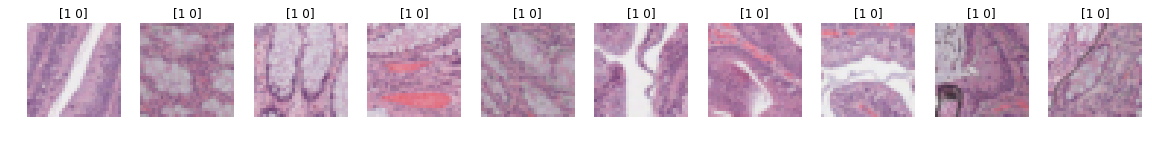

In [41]:
hf.show_labeled_patches(dataset.train.images[100:110], dataset.train.labels[100:110])

In [78]:
train_batch_size = 64
test_batch_size = train_batch_size # or, validation batch size

# TODO for now, since only 1 training set, no switching of training sets during training.
def train_model(num_epochs, k, epochs_per_iteration=1):

    # Calculate how many iterations per epoch based on batch size
    it_per_epoch = math.ceil(dataset.train.num_images / train_batch_size)
    
    for epoch in range(num_epochs):
        optimize(dataset.train, it_per_epoch, epoch=epoch, it_per_epoch=it_per_epoch)
        print_test_accuracy(dataset.valid, show_confusion_matrix=False)


In [79]:
train_model(25, k)

Optimization Iteration:      1, Training Accuracy:  12.5%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      2, Training Accuracy:  15.6%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      3, Training Accuracy:  17.2%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      4, Training Accuracy:  15.6%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      5, Training Accuracy:  14.1%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      6, Training Accuracy:  29.7%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      7, Training Accuracy:  32.8%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      8, Training Accuracy:  28.1%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      9, Training Accuracy:  25.0%
======== Accuracy on v

In [80]:
train_model(25, k)

Optimization Iteration:      1, Training Accuracy:  60.9%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      2, Training Accuracy:  57.8%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      3, Training Accuracy:  57.8%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      4, Training Accuracy:  73.4%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      5, Training Accuracy:  75.0%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      6, Training Accuracy:  76.6%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      7, Training Accuracy:  79.7%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      8, Training Accuracy:  70.3%
======== Accuracy on validation set: 75.5% (2913 / 3860)
Optimization Iteration:      9, Training Accuracy:  71.9%
======== Accuracy on v

In [63]:
len(labels_to_class)

14703